In [1]:
from pykoges import codingbook, koges, stats

1. 코딩북 읽기

In [2]:
q = codingbook.read(folder_name='./data_fixed/')
# q.summary()

코딩북 읽어오는중...:   0%|          | 0/20 [00:00<?, ?it/s]

2. 변수 설정

In [3]:
x_list = {
    "stiffness", "bonet", "bonez",  # bone stiffness/T/Z
    
    # "glu0",  # glucose, 결측치가 많아서 폐기
    "uricacid",  # gout
    # "insul_fbs", # insulin(fbs)
    # 호흡
    "fvc", "fev1", "fef25",
    # 신체계측
    "waist", "hip", "bparmc",
    "weight", "height", # bmi가 필요하면 이 두개로 생성
    # 신장
    "bun", "creatine",
    "u_ph",
    # "glu16_u",
    # 대사
    "ldl", "tg", "hdl", "tchl",  # cholesterol
    "albumin",  # albumin
    "ast", "alt", "r_gtp",
    "t_bil", "u_ket",

    # 순환
    "rabi", "labi", "pulse", # right/left ABI
    # 기초
    "age",
    "grwhich", "gripl1", "gripr1", # 주 사용손/왼손/오른손 악력
    
    # CBC 지표
    "hb", "hct",
    "mcv", "mch", "mchc",
    "rbc", "wbc", "plat",

    "crp",
    "muscle",
    # "incell", "excell", "pbf", #inbody, muscle을 예측할때 제외
}

y_list = {
    # "muscle" # 근육량
    # "gripr1", "gripl1", "grwhich"  # 악력
    # "ekg",  # OX, EKG이상
    # "dm" # OX, 당뇨
    "code1", # 이산, EKG소견 (미네소타 코드)

    # "hba1c", # 연속 
    # "glu0" # 연속, 결측치가 많아서 폐기
    # "glu_fbs" # 연속, 결측치가 많아서 폐기
    # "strk4", # OX, dysphagia, 결측치가 많아서 폐기
    # 'nuchronic5' # OX, 골다공증, 결측치가 많아서 폐기
}

# 중복되는 환자 데이터를 통합하기 위해 사용하는 변수
patientinfo_list = {
    "cp", # 휴대폰 번호
    "name",  # 이름
    "birthday",  # 생년월일
    "socialno1",  # 주민번호 앞자리
    "socialno2",  # 주민번호 뒷자리
}

var = koges.Variables(
    q=q,
    x_list=x_list,
    y_list=y_list,
    patientinfo_list=patientinfo_list,
)
var.summary(
    display_datainfo=False,
    display_userinfo=False,
)

2. 데이터 읽기

In [4]:
kg = koges.read(
    variables=var,
    folder_name='./data_fixed/',
    filter_patient=True,
)

  0%|          | 0/20 [00:00<?, ?it/s]

3. 데이터 전처리

In [5]:
from pykoges.utils import div, mul

eps = 1e-9
y = kg.y[0]
custom_functions = []
if y == "dm": #dm여부
    custom_functions = [
        (["hb", "plat"], div),
        (["bun", "ldl"], div),
        (["ast", "tchl"], div),
        (["bonet", "bonez"], lambda a, b: (b * (b - a)) ** 2),
        (["stiffness", "height"], lambda a, b: b * (b - a) ** (1 / 2)),
        (["uricacid", "t_bil"], div),
        (["fev1", "fvc"], lambda a, b: a / (a + b + eps) * 100),
        # (['fvc', 'fev1', 'hct', 'plat'], lambda a,b,c,d:(a+b)*(c+d)),
    ]
elif y == "ekg": #ekg여부
    custom_functions = [
        (["bonet", "bonez"], lambda a, b: (b * (b - a)) ** 2),
        (["fev1", "fvc"], lambda a, b: a / (a + b + eps) * 100),
        (["muscle", "weight"], lambda a, b: (b * (b - a))),
        (["ast", "tchl"], mul),
        (["hb", "hct"], mul),
        (["height", "pulse"], lambda a, b: (b * (a - b))),
        (["alt", "ldl"], lambda a, b: (b - a) / (b + a + eps) * 100),
    ]
elif y == "code1": #ekg소견
    custom_functions = [
        (["hb", "hct"], div),
        (["ast", "alt"], div),
        (["muscle", "hdl"], div),
        # (["albumin", "alt"], div),
        # (["hdl", "tchl"], div),
        # (["tg", "tchl"], div),
        (["bun", "creatine"], mul),
    ]
elif y == "gripr1": #악력
    custom_functions = [
        (["ast", "tchl"], mul),
        (["alt", "tg"], mul),
        (["bun", "u_ph"], div),
        (["wbc", "mcv"], div),
        (["pulse", "crp"], mul),
    ]

In [6]:
kg_converted = koges.convert(
    koges=kg,
    muscle_weight_ratio=False,
    muscle_height_ratio=False,
    muscle_bmi_ratio=False,
    waist_hip_ratio=False,
    fev_fvc_ratio=False,
    grip_of_grwhich=True,
    weight_height_bmi=False,
    custom_functions=custom_functions,
)

In [7]:
kg_dropped = koges.drop(
    koges=kg_converted,
    drop_threshold=0.2,
    filter_alpha=3,
    data_impute=False,
    #
    display_result=True,
    display_count=True,
)

수행,데이터,비율,변수
전체 데이터,726,100%,37
결측치가 20% 이상인입력변수 제거,,,-19
결측치 제거,-78,-10%,0
3SD 초과제거,-79,-10%,0
최종데이터,569,78%,18


데이터 개수
track    22      70
         21      62
         20      52
         11     201
         08     168
baseline 11      16
total           569

### 4. 통계분석

#### 1) 데이터 분리

In [8]:
kg_splitted = stats.split(
    koges=kg_dropped,
    n_class=4,
    p_threshold=0.05,
    with_normality=False,
    with_homogenity=False,
)

-----------------
상위 4개 소견 398개


응답내용,n,%
sinus arrhythmia,209,52.51
LVH,94,23.62
BBB,54,13.57
A fib,41,10.3


#### 2) 통계분석

In [9]:
if kg_splitted.n_class == 2:
    kg_stats = stats.t_test(koges=kg_splitted)
else:
    kg_stats = stats.anova(koges=kg_splitted)

-----------------------
유효변수 17개
Albumin, Age, TG, 허리둘레, PLT, 맥박, 체중, 팔둘레, γ-GTP, WBC, 키, 엉덩이 둘레, Cholesterol, (Hb/Hct), (AST/ALT), (근육량/HDL), (BUN*Creatine)


In [10]:
stats.summary(koges=kg_stats)

-----------------------
ANOVA 결과


-----------------------
BoxPlot


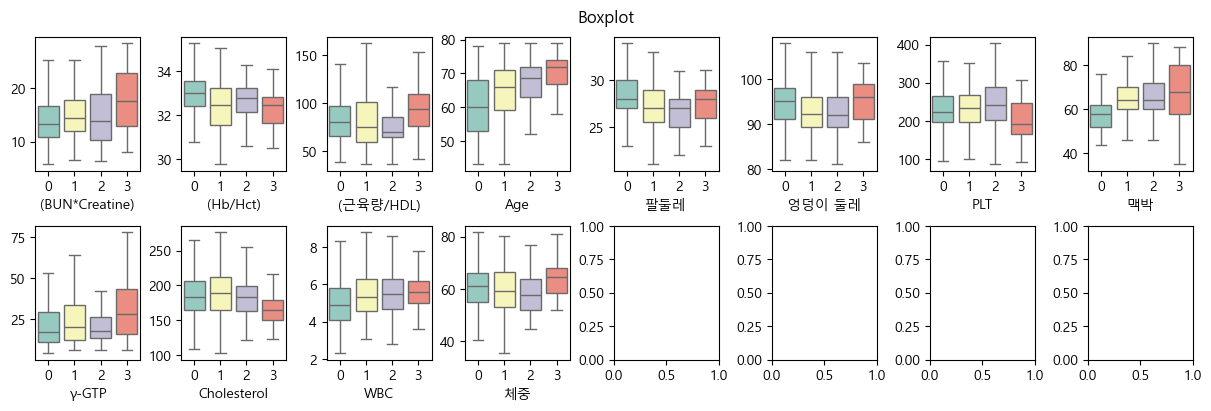

In [11]:
stats.boxplot(koges=kg_stats)

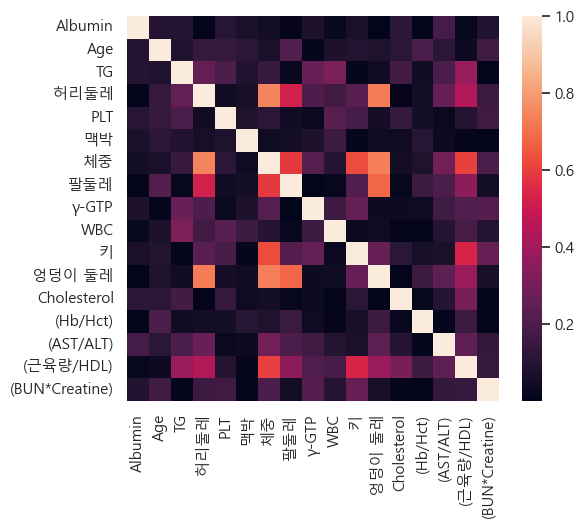

In [12]:

stats.correlation(koges=kg_stats)

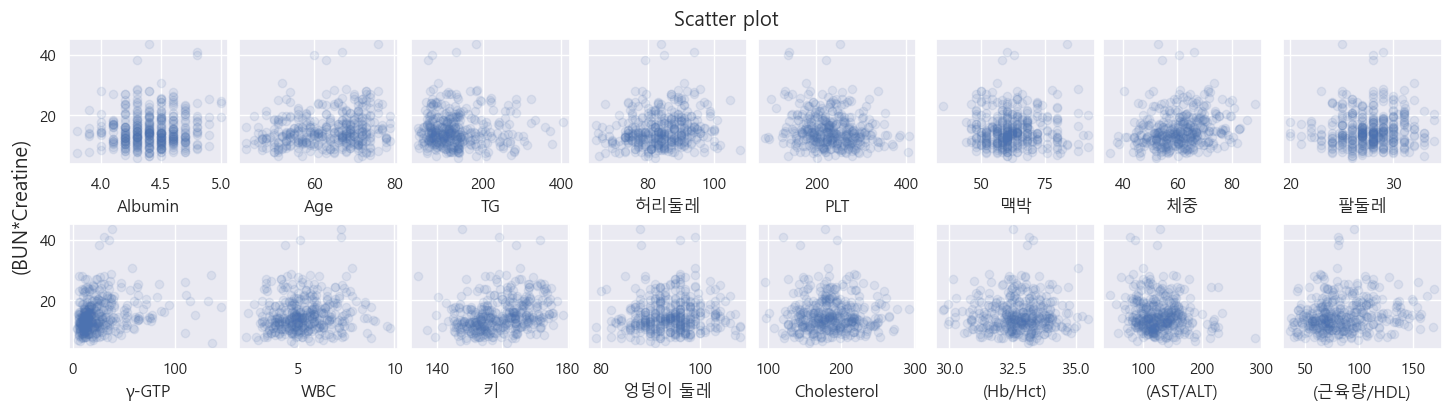

In [13]:
stats.scatter(koges=kg_stats)

### 5. 머신러닝

#### 1) 